# INTRODUCTION

The main processes on an image are:
  
1. **Undistort:** camera calibration matrix and distortion coefficients (using chessboard)
2. **Binarize:** color thresholding, gradient thresholding, etc.
3. **Birdeye:** prespective transform -> applied to binary image
4. **Polynomial curve fitting:** sliding window, histogram
5. **Compure offset:** from the center of lane
6. **Draw surface:** enclosed between two lanes

**For the video:** it's the same thing for the most part. It's just that in video (sequence of frames/images) we can infer lane lines based on previous frames.

***
# CAMERA CALIBRATION AND UNDISTORT

**STEPS:**

1. Number of inside corners: `nx`, `ny`
2. Make a list of calibration images: `for fname in glob.glob(camera_cal/*.jpg)`, `img = cv2.imread(fname)`
3. Convert to grayscale: `gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)`
4. Find the chessboard corners: `ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)`
5. If corners found (`if ret:`), draw and display corners: `cv2.drawChessboardCorners(img, (nx, ny), corners, ret)`, `plt.imshow(img)`
6. Having object points and image points, we can use `cv2.calibrateCamera()` for calibration. It returns the camera matrix, distortion coefficients, rotation and translation vectors etc.
7. Having camera matrix and distortion parameters, we can **_undistort_** images using `cv2.undistort(img, mtx, dist, None, newcameramtx)`, where `newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))` and `h,  w = img.shape[:2]`. 
8. We can use the **_ROI_** to crop the image: `x,y,w,h = roi`, `dst = dst[y:y+h, x:x+w]` and `cv2.imwrite('calibresult.png',dst)`.

**NOTE:** camera calibration should be only done once. So, in videos, onces you calibrated the camera first time/frame just save it and for the next frames just load that calibration.

- [OpenCV source](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_calib3d/py_calibration/py_calibration.html)
- [Other sources-1](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html)
- [Other sources-2](https://docs.opencv.org/2.4/doc/tutorials/calib3d/camera_calibration/camera_calibration.html)
- [Other sources-3](https://www.mathworks.com/help/vision/ug/camera-calibration.html)

**On `numpy.meshgrid` & `numpy.mgrid`:** Refer to [this page](http://louistiao.me/posts/numpy-mgrid-vs-meshgrid/)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob

In [11]:
class Undistort:
    
    def __init__(self, nx, ny):
        self.nx = nx
        self.ny = ny
        self.mtx = None
        self.dist = None
        self.rvecs = None
        self.tvecs = None
        
    def calibrate(self, cal_img_pth):
        
        # 3D real world and image plance arrays
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image plane.

        images = glob.glob('{}/*.jpg'.format(cal_img_pth))
        for fname in images:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)
        ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv2.calibrateCamera(objpoints, 
                                                                               imgpoints, 
                                                                               gray.shape[::-1], 
                                                                               None, 
                                                                               None)
    def undistort(self, img_pth):
        return cv2.undistort(cv2.imread(img_pth), 
                             self.mtx, self.dist, 
                             newCameraMatrix=self.mtx)
    
    def show_undistorted(self, img_pth):
        fig, ax = plt.subplots(1, 2, figsize=(20,15))
        img = cv2.imread(img_pth)
        img_undistorted = self.undistort(img_pth)
        ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax[1].imshow(cv2.cvtColor(img_undistorted, cv2.COLOR_BGR2RGB))
        ax[0].set_title('Distorted')
        ax[1].set_title('Undistorted')
        plt.show()      

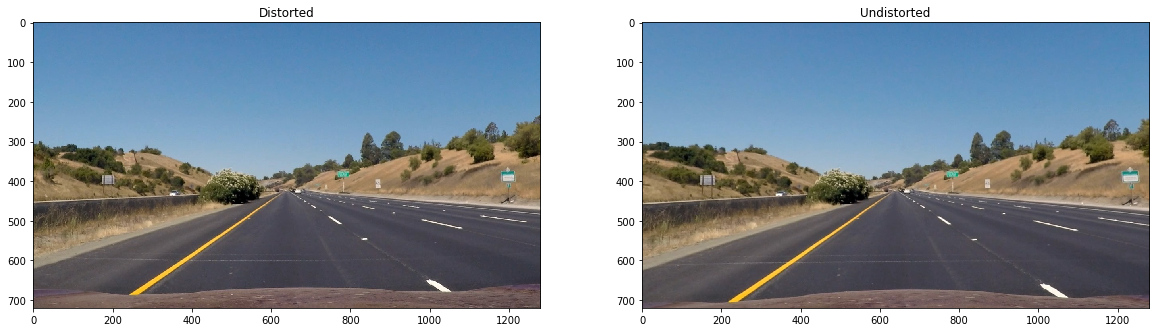

In [12]:
undist = Undistort(nx=9, ny=6)
undist.calibrate(cal_img_pth='camera_cal')
undist.show_undistorted(img_pth='test_images/straight_lines1.jpg')

# Binarize

# Thresholding Colors

In [71]:
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

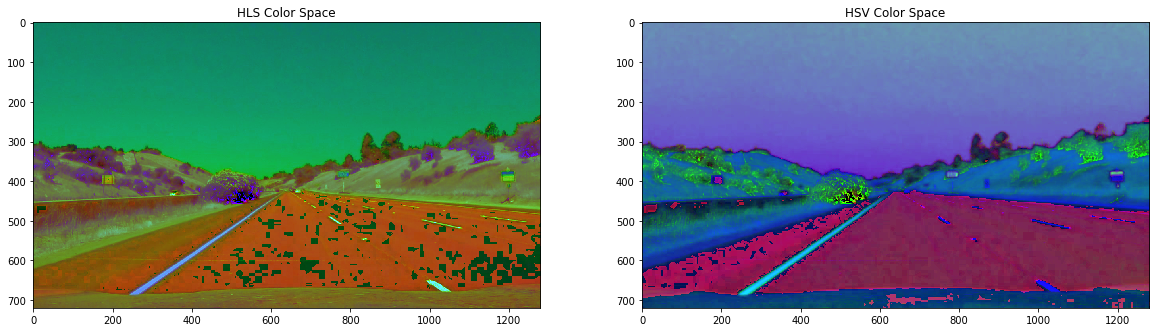

In [72]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,15))
ax[0].imshow(hls)
ax[1].imshow(hsv)
ax[0].set_title('HLS Color Space')
ax[1].set_title('HSV Color Space')
plt.show()

In [73]:
hls_min_thres = np.array([0, 0, 90])
hls_max_thres = np.array([255, 255, 255])
hsv_min_thres = np.array([0, 70, 70])
hsv_max_thres = np.array([50, 255, 255])

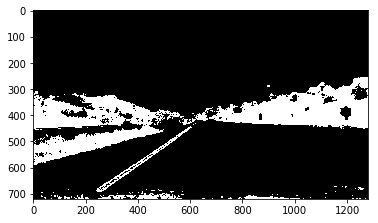

In [74]:
hsv_min = np.all(hsv > hsv_min_thres, axis=2)
hsv_max = np.all(hsv < hsv_max_thres, axis=2)
hsv_th = np.logical_and(hsv_min, hsv_max)
plt.imshow(hsv_th, cmap='gray')

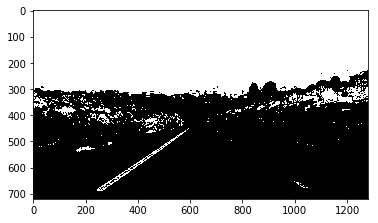

In [75]:
hls_min = np.all(hls > hls_min_thres, axis=2)
hls_max = np.all(hls < hls_max_thres, axis=2)
hls_th = np.logical_and(hls_min, hls_max)
plt.imshow(hls_th, cmap='gray')

# Gradient Thresholding - Sobel

In [89]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

kernel_size = 1
sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)

gradmag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
# Rescale to 8 bit
scale_factor = np.max(gradmag)/255 
gradmag = (gradmag/scale_factor).astype(np.uint8)

# Create a binary image of ones where threshold is met, zeros otherwise

#### first way
mag_thresh = [100, 100]
binary_output = np.zeros_like(gradmag)
# binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
binary_output[(gradmag >= 50)] = 1


#### second way
sobel_mag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
sobel_mag = np.uint8(sobel_mag / np.max(sobel_mag) * 255)
_, sobel_mag = cv2.threshold(sobel_mag, 50, 1, cv2.THRESH_BINARY)

## Combining Color and Gradient Threshold

- For this write a pipeline function

In [77]:
height, width = img.shape[:2]

binary = np.zeros((height, width))

# add masks from hsv and hls
binary_hsv = np.logical_or(binary, hsv_th)

binary = np.zeros((height, width))
binary_hls = np.logical_or(binary, hls_th)


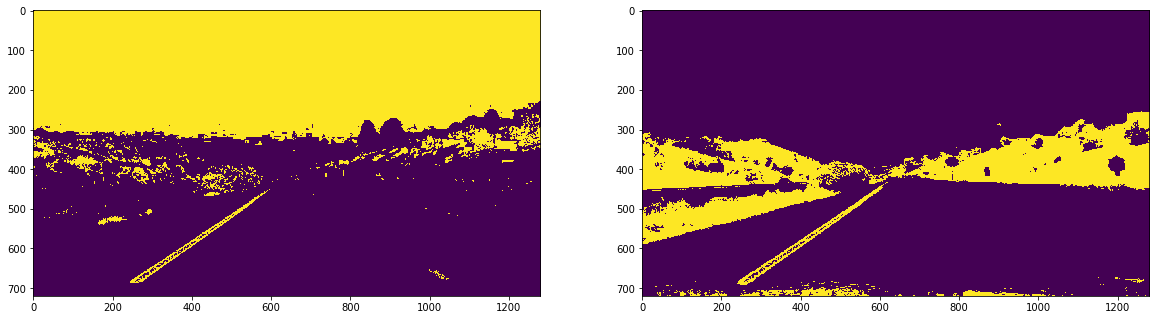

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(20,15))
ax[0].imshow(binary_hls)
ax[1].imshow(binary_hsv)
plt.show()

In [79]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
eq_global = cv2.equalizeHist(gray)
_, th = cv2.threshold(eq_global, thresh=250, maxval=255, type=cv2.THRESH_BINARY)

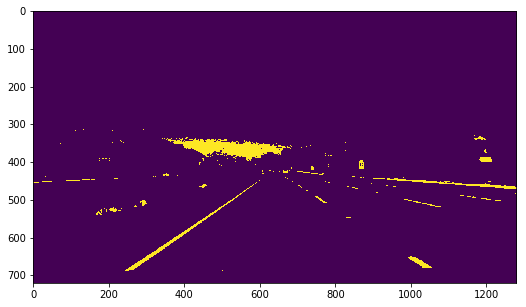

In [80]:
# highlight white lines by thresholding the equalized frame
binary = np.zeros((height, width))
binary_th = np.logical_or(binary, th)
plt.figure(figsize=(15,5))
plt.imshow(binary_th)

## Sobel

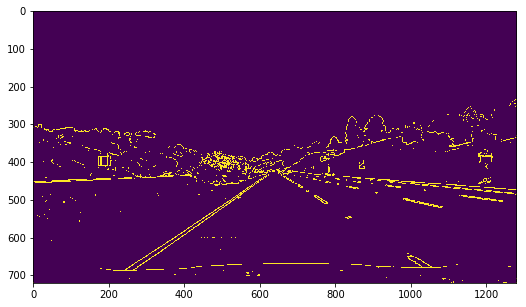

In [81]:
# apply Sobel binary mask (thresholded gradients)
binary = np.zeros((height, width))
#sobel_mask = thresh_frame_sobel(img, kernel_size=9)
binary_sobel = np.logical_or(binary, sobel_mag)
plt.figure(figsize=(15,5))
plt.imshow(binary_sobel)

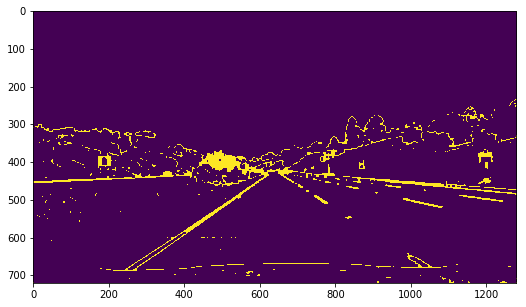

In [82]:
# apply a light morphology to "fill the gaps" in the binary image
kernel = np.ones((5, 5), np.uint8)
closing = cv2.morphologyEx(binary_sobel.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
plt.figure(figsize=(15,5))
plt.imshow(closing)

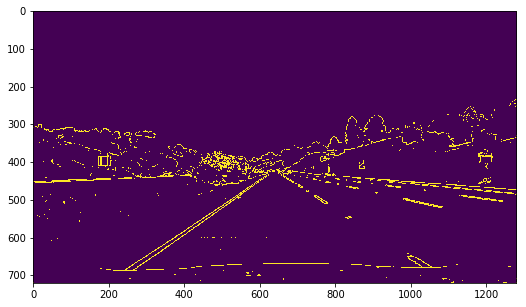

In [83]:
# apply Sobel binary mask (thresholded gradients)
binary = np.zeros((height, width))
#sobel_mask = thresh_frame_sobel(img, kernel_size=9)
binary_sobel2 = np.logical_or(binary, binary_output)
plt.figure(figsize=(15,5))
plt.imshow(binary_sobel2)

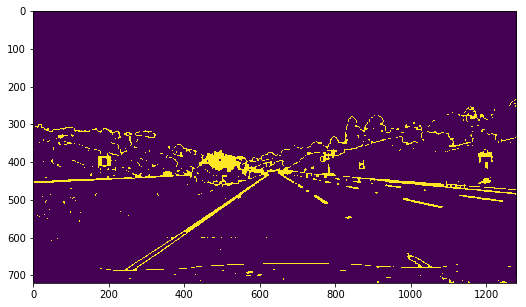

In [84]:
# apply a light morphology to "fill the gaps" in the binary image
kernel = np.ones((5, 5), np.uint8)*1
closing2 = cv2.morphologyEx(binary_sobel2.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
plt.figure(figsize=(15,5))
plt.imshow(closing2)

## Making the binary

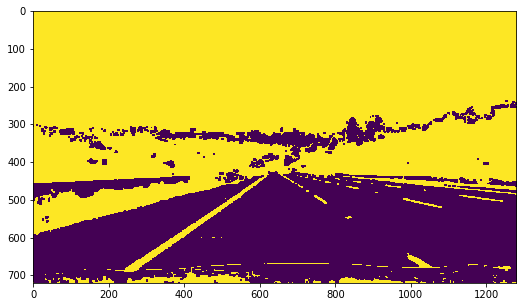

In [91]:
height, width = img.shape[:2]

binary = np.zeros((height, width))

# add masks from hsv and hls
binary = np.logical_or(binary, hsv_th)
binary = np.logical_or(binary, hls_th)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
eq_global = cv2.equalizeHist(gray)
_, th = cv2.threshold(eq_global, thresh=250, maxval=255, type=cv2.THRESH_BINARY)

binary = np.logical_or(binary, th)

binary = np.logical_or(binary, sobel_mag)

closing = cv2.morphologyEx(binary.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
plt.figure(figsize=(15,5))
plt.imshow(closing)

## Perspective Transform

In [92]:
%matplotlib inline

In [122]:
nx = 9
ny = 6

In [157]:
img = cv2.imread('test_images/straight_lines2.jpg')

In [158]:
# Use the OpenCV undistort() function to remove distortion
undist = cv2.undistort(img, mtx, dist, None, mtx)

In [159]:
# Convert undistorted image to grayscale
gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)

In [160]:
# Search for corners in the grayscaled image
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

In [161]:
# of course, not a chessboard so no corners
type(corners)

NoneType

In [162]:
offset = 100 # offset for dst points
# Grab the image shape
img_size = (gray.shape[1], gray.shape[0])

In [163]:
h, w = img.shape[:2]

src = np.float32([[w, h-10],    # br
                  [0, h-10],    # bl
                  [546, 460],   # tl
                  [732, 460]])  # tr
dst = np.float32([[w, h],       # br
                  [0, h],       # bl
                  [0, 0],       # tl
                  [w, 0]])      # tr

In [164]:
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

warped = cv2.warpPerspective(img, M, (w, h), flags=cv2.INTER_LINEAR)

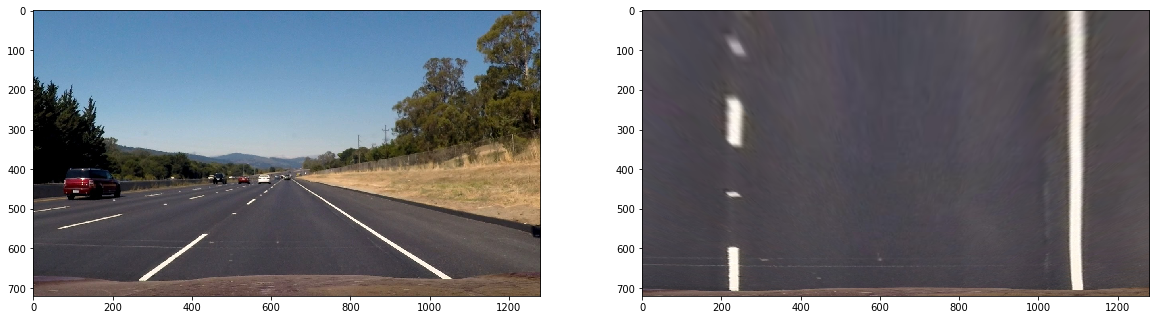

In [165]:
fig, ax = plt.subplots(1, 2, figsize=(20,15))
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.show()

# Finding Lane Lines & Measuring Curvature

## Simple Histogram

In [166]:
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)

In [167]:
bottom_half = warped[warped.shape[0]//2:,:]

In [168]:
histogram = np.sum(bottom_half, axis=0)

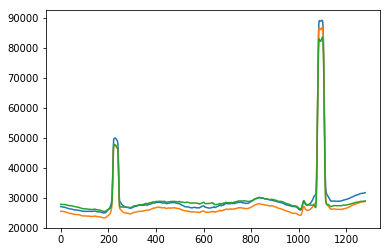

In [169]:
plt.plot(histogram)

## Sliding Window

## Sliding window convolution

## Search From prior